# Previsão de churn (abandono) em telecom

### Referências:
- https://github.com/RomeroBarata/IF702-redes-neurais

### Grupo 8:
- Erbert Gadelha (ebgr)
- João Pedro (jpba)
- Vinicius Barbosa (vrb)
- Almir Alves (aasc)
- Felipe Mateus (fmfb)

# Preparação e importação da base de dados

In [1]:
#@title Instalações

# scikit plot
!pip install scipy==1.11.4 scikit-plot

# optuna
!pip install optuna

# STab
!pip install keras4torch
!pip install einops
!pip install tab-transformer-pytorch

# TensorFlow
!pip install tensorflow==2.15


!git clone https://github.com/kailanefelix/stab-redes-neurais.git

!ls
%cd stab-redes-neurais
!mv STAB STab

  Using cached tab_transformer_pytorch-0.4.2-py3-none-any.whl.metadata (914 bytes)
  Using cached hyper_connections-0.2.1-py3-none-any.whl.metadata (6.0 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux20

Cloning into 'stab-redes-neurais'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 97 (delta 43), reused 20 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (97/97), 62.40 KiB | 10.40 MiB/s, done.
Resolving deltas: 100% (43/43), done.
sample_data  stab-redes-neurais
/content/stab-redes-neurais


In [2]:
#@title Importações
# basic
import kagglehub
import numpy as np
import numpy.typing as npt
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

import scikitplot as skplt

# sklearn
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score, f1_score, mean_squared_error

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# optuna
import optuna

# Keras4Torch
import keras4torch
from keras4torch.callbacks import ModelCheckpoint, LRScheduler

# STab
import STab
from STab import mainmodel, LWTA, Gsoftmax, Num_Cat
from einops import rearrange
from tab_transformer_pytorch import TabTransformer

# fix random seed
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
#@title Download data and create DataFrame
churn_data_path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")
print("Path to dataset files:", churn_data_path)

churn_df = pd.read_csv(churn_data_path + "/customer_churn_telecom_services.csv")
print(f"Data shape {churn_df.shape}")
churn_df.head()

Path to dataset files: /kaggle/input/customers-churned-in-telecom-services
Data shape (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploração dos dados

### Descrição das colunas:

| Column Name | Description |
|-------------|-------------|
| gender | Customer's gender (Male/Female) |
| SeniorCitizen |	Indicates if the customer is a senior citizen (1 = Yes, 0 = No) |
| Partner | Whether the customer has a partner (Yes/No) |
| Dependents | Whether the customer has dependents (Yes/No) |
|tenure |	Number of months the customer has stayed with the company |
|PhoneService |	Whether the customer has a phone service (Yes/No) |
|MultipleLines | Whether the customer has multiple phone lines (No, Yes, No phone service) |
|InternetService | Type of internet service (DSL, Fiber optic, No) |
|OnlineSecurity |	Whether the customer has online security (Yes, No, No internet service) |
|OnlineBackup |	Whether the customer has online backup (Yes, No, No internet service) |
|DeviceProtection |	Whether the customer has device protection (Yes, No, No internet service) |
|TechSupport | Whether the customer has tech support (Yes, No, No internet service) |
|StreamingTV | Whether the customer has streaming TV (Yes, No, No internet service) |
|StreamingMovies |	Whether the customer has streaming movies (Yes, No, No internet service) |
|Contract |	Type of contract (Month-to-month, One year, Two year) |
|PaperlessBilling |	Whether the customer has paperless billing (Yes/No) |
|PaymentMethod | Payment method used (Electronic check, Mailed check, Bank transfer, Credit card) |
|MonthlyCharges |	Monthly charges the customer pays |
|TotalCharges |	Total amount charged to the customer |
|Churn |	Whether the customer has churned (Yes/No) |

## Verificando valores nulos

In [4]:
#@title Verificando o dataset
churn_df.info()
nulls = churn_df['TotalCharges'].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


A colunas `TotalCharges` possui 11 valores nulos, portanto essas amostras serão removidas.

In [5]:
#@title Removendo valores nulos
print(f"Data shape (before cleaning) {churn_df.shape}")
churn_df = churn_df.dropna()
print(f"Data shape (after cleaning) {churn_df.shape}")

Data shape (before cleaning) (7043, 20)
Data shape (after cleaning) (7032, 20)


## Verificando outliers

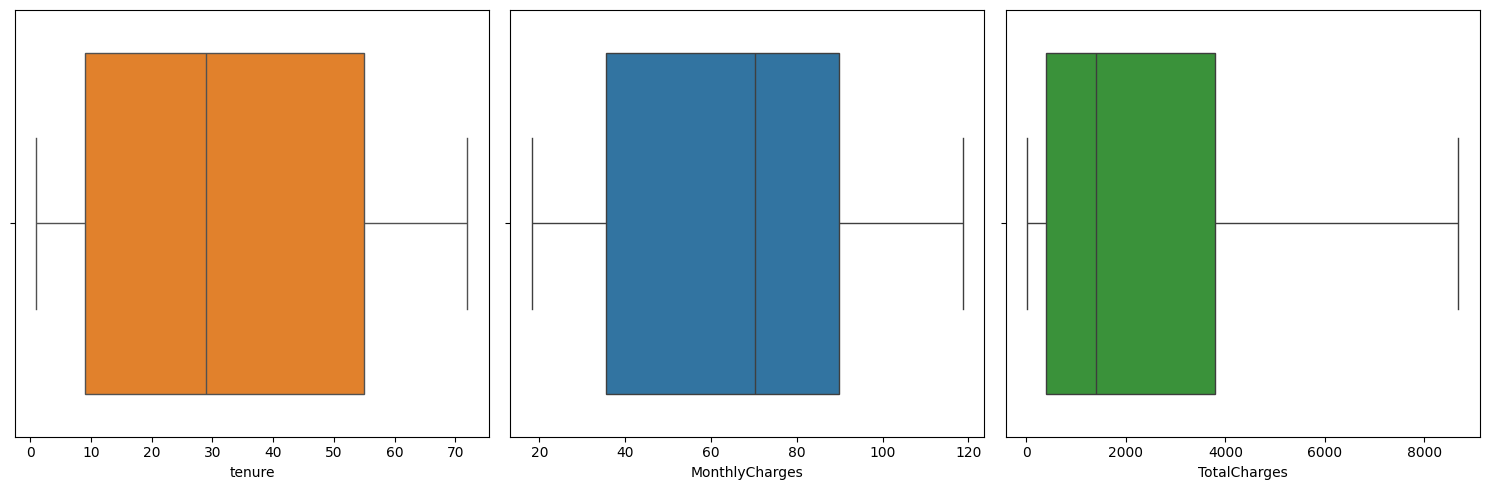

In [6]:
#@title Verificando a existência de outliers

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
colors = ['tab:orange', 'tab:blue', 'tab:green']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(numerical_features):
  sns.boxplot(churn_df, x=feature, ax=axes[i], color=colors[i])
plt.tight_layout()

## Analisando distribuições

### Features Contínuas

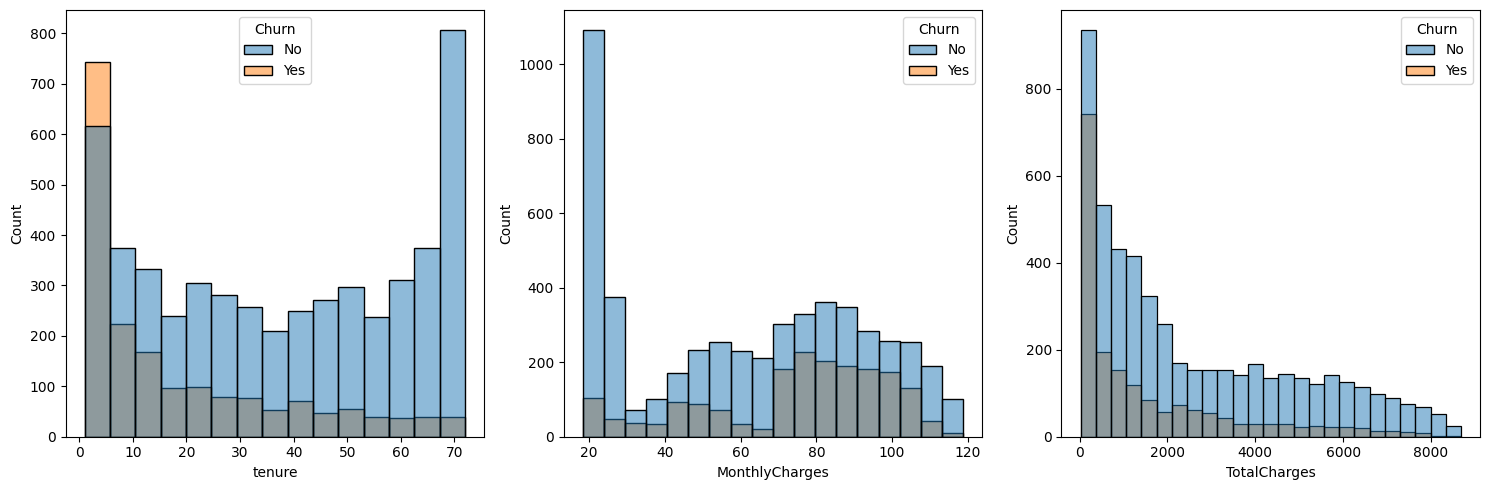

In [7]:
#@title Histograma por abandono

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(numerical_features):
  sns.histplot(churn_df, x=feature, ax=axes[i], hue='Churn')
plt.tight_layout()
plt.show()

A partir das distribuições podemos deduzir os seguintes pontos:
*   Clientes jovens tendem a abandonar mais, enquanto pessoas com mais idade tendem a continuar sendo clientes
*   Cobranças mensais muito baixas contribuem para uma alta taxa de fidelidade, mas valores mais altos não apresentam uma influência notável



# Preparação dos dados

In [8]:
#@title Convertendo tipos categóricos

cat_df = churn_df.select_dtypes(include=['object', 'category'])
for col in cat_df.columns:
  churn_df[col] = churn_df[col].astype('category')
  churn_df[col] = churn_df[col].cat.codes

  if col == 'Churn':
    continue

  # one hot encode if more than 2 alternatives
  if len(churn_df[col].unique()) > 2:
    churn_df = pd.concat([churn_df, pd.get_dummies(churn_df[col], prefix=col)], axis=1)
    churn_df = churn_df.drop(columns=[col])

churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              7032 non-null   int8   
 1   SeniorCitizen       7032 non-null   int64  
 2   Partner             7032 non-null   int8   
 3   Dependents          7032 non-null   int8   
 4   tenure              7032 non-null   int64  
 5   PhoneService        7032 non-null   int8   
 6   PaperlessBilling    7032 non-null   int8   
 7   MonthlyCharges      7032 non-null   float64
 8   TotalCharges        7032 non-null   float64
 9   Churn               7032 non-null   int8   
 10  MultipleLines_0     7032 non-null   bool   
 11  MultipleLines_1     7032 non-null   bool   
 12  MultipleLines_2     7032 non-null   bool   
 13  InternetService_0   7032 non-null   bool   
 14  InternetService_1   7032 non-null   bool   
 15  InternetService_2   7032 non-null   bool   
 16  OnlineSecur

In [9]:
#@title Divisão estratificada Treino / Validação / Teste (50% / 25% / 25%)
X = churn_df.drop(columns=['Churn'])
y = churn_df['Churn']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train shape {X_train.shape}")
print(f"Validation shape {X_val.shape}")
print(f"Test shape {X_test.shape}")

Train shape (3516, 40)
Validation shape (1758, 40)
Test shape (1758, 40)


In [10]:
#@title Normalização das features numéricas

mean_train = X_train.mean()
std_train = X_train.std()

X_train_n = X_train.copy(deep=True)
X_val_n = X_val.copy(deep=True)
x_test_n_array = X_test.copy(deep=True)

for col in numerical_features:
  X_train_n[col] = (X_train[col] - mean_train[col]) / std_train[col]
  X_val_n[col] = (X_val[col] - mean_train[col]) / std_train[col]
  x_test_n_array[col] = (X_test[col] - mean_train[col]) / std_train[col]

print("===========================================================================")
print("Distribuições do conjunto de treino")
print("===========================================================================")
print(X_train.describe())
print("===========================================================================")
print("Distribuições (normalizadas) do conjunto de treino")
print("===========================================================================")
print(X_train_n.describe())

Distribuições do conjunto de treino
            gender  SeniorCitizen      Partner   Dependents       tenure  \
count  3516.000000    3516.000000  3516.000000  3516.000000  3516.000000   
mean      0.503982       0.165529     0.483788     0.300910    32.577361   
std       0.500055       0.371710     0.499808     0.458719    24.400907   
min       0.000000       0.000000     0.000000     0.000000     1.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       1.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000    72.000000   

       PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  
count   3516.000000       3516.000000     3516.000000   3516.000000  
mean       0.905575          0.593572       65.079238   2304.446217  
std        0.292461          0.491236       30.200006   2264.169199  

# Métodos auxiliares

In [11]:
#@title Plot do Teste Kolmogorov-Smirnov

def plot_ks(y_true: npt.NDArray, y_pred: npt.NDArray):
  skplt.metrics.plot_ks_statistic(y_true, y_pred)
  plt.show()

In [12]:
#@title Plot da Matriz de Confusão

def plot_conf_matrix(cm):
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

In [13]:
#@title Plot da curva ROC

def plot_roc(fpr, tpr, auc, label):
  plt.figure(figsize=(6, 6))
  plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')
  plt.plot([0, 1], [0, 1], '--', color='tab:orange')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()

In [14]:
#@title Plot das curvas de erro do treinamento

def plot_training_error_curves(history, loss):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel=f'Loss ({loss})')
    ax.legend()
    plt.show()

# Execução inicial com classificadores

In [15]:
#@title Parâmetros gerais
epochs = 10000
patience = 20

## MLP

In [16]:
#@title Definição do modelo
mlp_classifier = Sequential()
mlp_classifier.add(Input(shape=(X_train.shape[1],)))
mlp_classifier.add(Dense(10, activation='relu'))
mlp_classifier.add(Dense(1, activation='sigmoid'))
mlp_classifier.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
mlp_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                410       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 421 (1.64 KB)
Trainable params: 421 (1.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
import numpy as np

X_train_array   = np.array(X_train).astype(np.float32)
X_val_array     = np.array(X_val).astype(np.float32)
X_test_array    = np.array(X_test).astype(np.float32)

X_train_array_n = np.array(X_train_n).astype(np.float32)
x_val_n_array   = np.array(X_val_n).astype(np.float32)
x_test_n_array  = np.array(x_test_n_array).astype(np.float32)

y_train_array = np.array(y_train).astype(np.float32)
y_val_array   = np.array(y_val).astype(np.float32)
y_test_array  = np.array(y_test).astype(np.float32)

In [18]:
print(X_train_array_n.dtype, y_train_array.dtype)
print(type(X_train_array_n), type(y_train_array))

float32 float32
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [19]:
#@title Treinamento inicial
mlp_history = mlp_classifier.fit(X_train_array_n, y_train_array, epochs=epochs, validation_data=(x_val_n_array, y_val_array),
                                 callbacks=[EarlyStopping(patience=patience, monitor='val_loss')])

Epoch 1/10000
110/110 [==============================] - 1s 3ms/step - loss: 0.2192 - val_loss: 0.1680
Epoch 2/10000
110/110 [==============================] - 0s 2ms/step - loss: 0.1526 - val_loss: 0.1487
Epoch 3/10000
110/110 [==============================] - 0s 2ms/step - loss: 0.1412 - val_loss: 0.1448
Epoch 4/10000
110/110 [==============================] - 0s 2ms/step - loss: 0.1376 - val_loss: 0.1432
Epoch 5/10000
110/110 [==============================] - 0s 2ms/step - loss: 0.1364 - val_loss: 0.1427
Epoch 6/10000
110/110 [==============================] - 0s 2ms/step - loss: 0.1355 - val_loss: 0.1421
Epoch 7/10000
110/110 [==============================] - 0s 2ms/step - loss: 0.1348 - val_loss: 0.1417
Epoch 8/10000
110/110 [==============================] - 0s 2ms/step - loss: 0.1343 - val_loss: 0.1415
Epoch 9/10000
110/110 [==============================] - 0s 2ms/step - loss: 0.1340 - val_loss: 0.1412
Epoch 10/10000
110/110 [==============================] - 0s 2ms/step - l

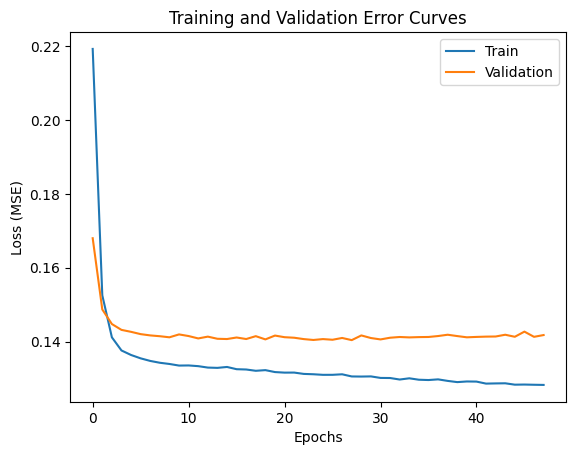

In [20]:
#@title Curvas de aprendizado

plot_training_error_curves(mlp_history, 'MSE')

### Avaliação inicial

In [21]:
#@title Gerando predições
mlp_preds = mlp_classifier.predict(x_test_n_array)
mlp_preds_scores_0 = 1 - mlp_preds
mlp_preds_scores = np.concatenate([mlp_preds_scores_0, mlp_preds], axis=1)

55/55 [==============================] - 0s 1ms/step


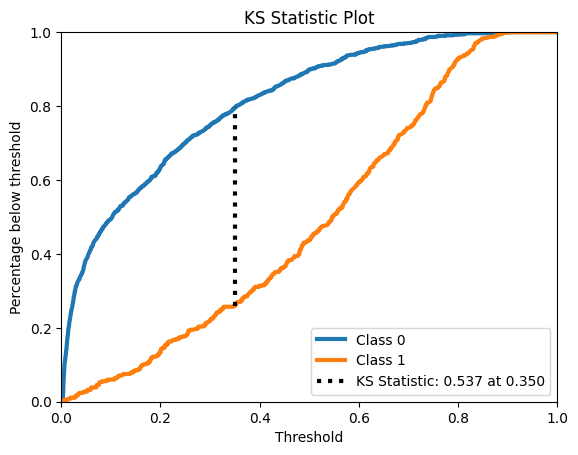

In [22]:
#@title Teste Kolmogorov-Smirnov
plot_ks(y_test, mlp_preds_scores)

In [23]:
#@title MSE
mlp_mse = mlp_classifier.evaluate(x_test_n_array, y_test_array, verbose=0)
print(f"MSE: {mlp_mse}")

MSE: 0.13489393889904022


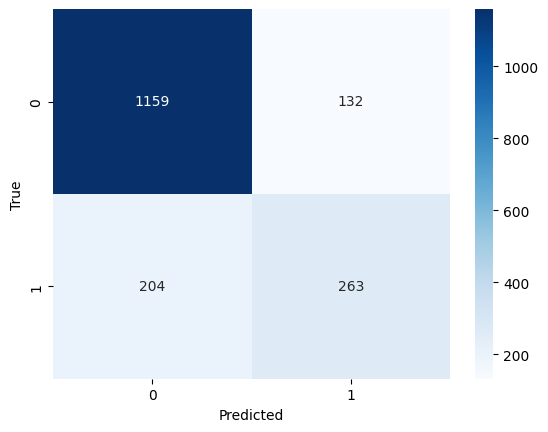

In [24]:
#@title Matriz de confusão
mlp_cm = confusion_matrix(y_test_array, np.round(mlp_preds))
plot_conf_matrix(mlp_cm)

AUC-ROC: 0.8462216597528268


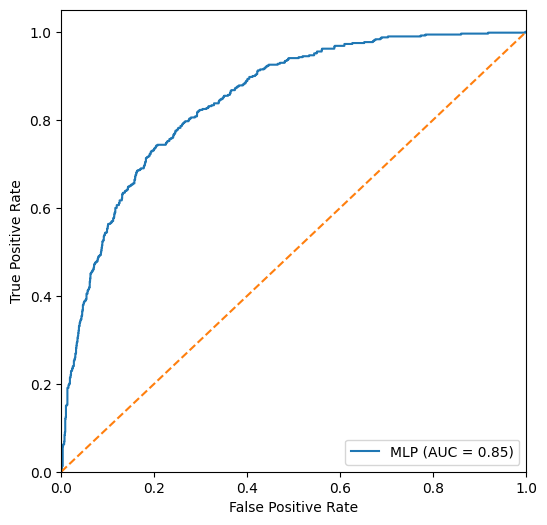

In [25]:
#@title AUC-ROC
mlp_auc = roc_auc_score(+y_test, mlp_preds)
print(f"AUC-ROC: {mlp_auc}")
mlp_fpr, mlp_tpr, _ = roc_curve(+y_test, mlp_preds)
plot_roc(mlp_fpr, mlp_tpr, mlp_auc, 'MLP')

In [26]:
#@title Recall, precision e f-score
mlp_recall = recall_score(y_test_array, np.round(mlp_preds))
mlp_precision = precision_score(y_test_array, np.round(mlp_preds))
mlp_f1 = f1_score(y_test, np.round(mlp_preds))
print(f"Recall: {mlp_recall}")
print(f"Precision: {mlp_precision}")
print(f"F1-score: {mlp_f1}")

Recall: 0.563169164882227
Precision: 0.6658227848101266
F1-score: 0.6102088167053364


## Random Forest

In [27]:
#@title Definição do modelo
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier

RandomForestClassifier(random_state=42)

In [28]:
#@title Treinamento inicial
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Avaliação inicial

In [29]:
#@title Gerando predições
rf_preds = rf_classifier.predict(X_test)
rf_preds_0 = 1 - rf_preds
rf_preds_scores = np.concatenate([rf_preds_0.reshape(-1, 1), rf_preds.reshape(-1, 1)], axis=1)
print(f"Predições: {rf_preds.shape}")

Predições: (1758,)


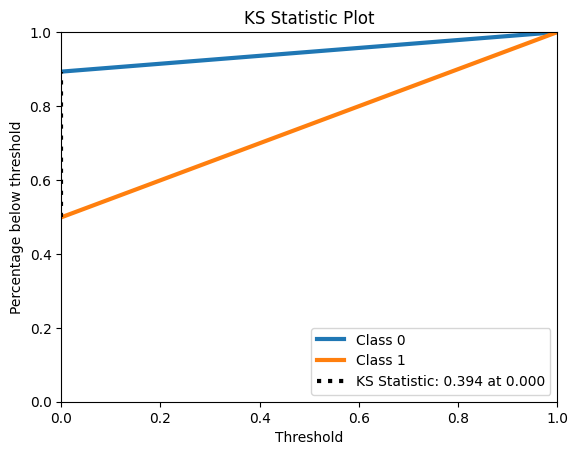

In [30]:
#@title Teste Kolmogorov-Smirnov
rf_ks = plot_ks(y_test, rf_preds_scores)

In [31]:
#@title MSE
rf_mse = mean_squared_error(y_test, rf_preds)
print(f"MSE: {rf_mse}")

MSE: 0.21103526734926054


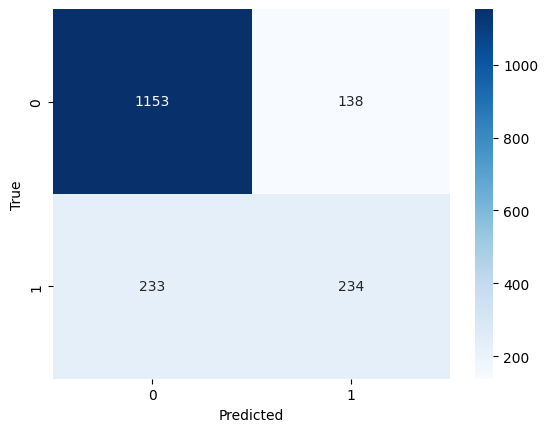

In [32]:
#@title Matriz de confusão
rf_cm = confusion_matrix(y_test, rf_preds)
plot_conf_matrix(rf_cm)

AUC-ROC: 0.6970883915494687


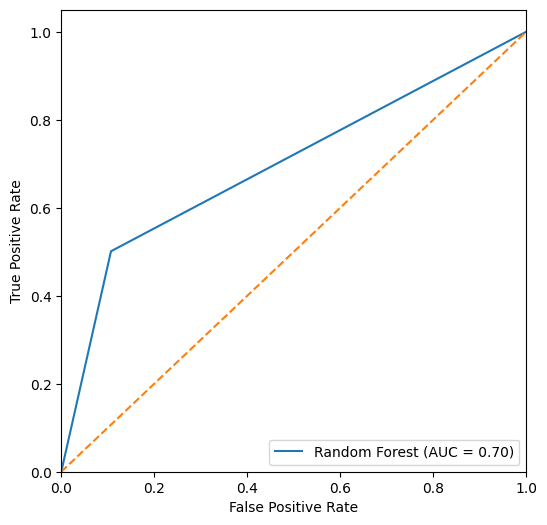

In [33]:
#@title AUC-ROC
rf_auc = roc_auc_score(y_test, rf_preds)
print(f"AUC-ROC: {rf_auc}")
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_preds)
plot_roc(rf_fpr, rf_tpr, rf_auc, 'Random Forest')

In [34]:
#@title Recall, precision e f-score
rf_recall = recall_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)
print(f"Recall: {rf_recall}")
print(f"Precision: {rf_precision}")
print(f"F1-score: {rf_f1}")

Recall: 0.5010706638115632
Precision: 0.6290322580645161
F1-score: 0.5578069129916567


# Otimizando classificadores iniciais

## MLP

In [35]:
#@title Otimização do MLP com Optuna

# A função de otimização para o MLP
def objective_mlp(trial):
    """
    Essa função tem o mesmo 'objetivo' da sua versão RF abaixo
    """

    model = Sequential() #modelo sequencial

    n_layers = trial.suggest_int('n_layers', 1, 2)

    #As n layers são adicionadas de acordo com os hiperparametros escolhidos
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 10, 100)
        activation = trial.suggest_categorical(f'activation_l{i}', ['relu', 'tanh', 'sigmoid'])#funções de ativação mais comuns
        model.add(Dense(n_units, activation=activation))

        #adiciona a camada de dropout
        dropout_rate = trial.suggest_float(f'dropout_l{i}', 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    #adiciona a camada de saída
    model.add(Dense(1, activation='sigmoid'))

    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer = Adam(learning_rate=learning_rate)
    loss = trial.suggest_categorical('loss', ['mse', 'binary_crossentropy']) # variando entre mse e cross-entropy

    #compilando o modelo 'treinado'
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['AUC'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    model.fit(X_train_array, y_train_array,
              validation_data=(X_val_array, y_val_array),
              epochs=10000,
              callbacks=[early_stopping],
              verbose=0)

    #avaliação do modelo
    val_auc = model.evaluate(X_val_array, y_val_array, verbose=0)[1]

    return val_auc

#otimização pelo optuna
print("Iniciando a busca pelos hiperparametros do MLP...")
study_mlp = optuna.create_study(direction='maximize')
study_mlp.optimize(objective_mlp, n_trials=50)#numero de tentativas para o MLP = 50 mas pode ser mudada

print("\n------------------Resultados da Otimização do MLP--------------------------")
print("Melhores hiperparametros encontrados:")
print(study_mlp.best_params)
print("\nMelhor area AUC no conjunto de validação:")
print(study_mlp.best_value)

[I 2025-08-11 00:42:50,341] A new study created in memory with name: no-name-62c557a5-fedf-4a99-acec-5d7a389db58c


Iniciando a busca pelos hiperparametros do MLP...


[I 2025-08-11 00:43:31,455] Trial 0 finished with value: 0.8212173581123352 and parameters: {'n_layers': 1, 'n_units_l0': 25, 'activation_l0': 'tanh', 'dropout_l0': 0.47058115771277503, 'learning_rate': 7.247465970480944e-05, 'loss': 'binary_crossentropy'}. Best is trial 0 with value: 0.8212173581123352.
[I 2025-08-11 00:43:49,823] Trial 1 finished with value: 0.830956220626831 and parameters: {'n_layers': 2, 'n_units_l0': 73, 'activation_l0': 'sigmoid', 'dropout_l0': 0.06705547093091857, 'n_units_l1': 81, 'activation_l1': 'relu', 'dropout_l1': 0.12326845683898974, 'learning_rate': 0.0001507557923664671, 'loss': 'mse'}. Best is trial 1 with value: 0.830956220626831.
[I 2025-08-11 00:44:09,674] Trial 2 finished with value: 0.8114453554153442 and parameters: {'n_layers': 2, 'n_units_l0': 63, 'activation_l0': 'sigmoid', 'dropout_l0': 0.48109635785546595, 'n_units_l1': 83, 'activation_l1': 'tanh', 'dropout_l1': 0.23723548240235942, 'learning_rate': 4.4592262233549805e-05, 'loss': 'mse'}. B


------------------Resultados da Otimização do MLP--------------------------
Melhores hiperparametros encontrados:
{'n_layers': 2, 'n_units_l0': 92, 'activation_l0': 'sigmoid', 'dropout_l0': 0.08310801177553839, 'n_units_l1': 50, 'activation_l1': 'relu', 'dropout_l1': 0.44229803077658963, 'learning_rate': 0.000325675910636547, 'loss': 'binary_crossentropy'}

Melhor area AUC no conjunto de validação:
0.8390214443206787


## Random Forest

In [36]:
#@title Otimização do Random Forest com Optuna

# A função de otimização de hiperparâmetros.
def objective_rf(trial):
    """
    Eu uso os dados de X e y definidos anteriormente. Para achar os melhores hiperparametros usando essa função objective_rf
    """
    # Sugere os hiperparâmetros, conforme a especificação do projeto.
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    #Aqui pega os melhores parametros achados e utiliza para criar um modelo com esse parametros
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )


    model.fit(X_train, y_train)


    y_pred = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred)

    return auc_score

# Cria o estudo do Optuna e executa a otimização
print("Iniciando a busca pelos hiperparametros do modelo Random Forest...")
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)

print("\n--- Resultados da Otimização do Random Forest ---")
print("Melhores hiperparametros encontrados:")
print(study_rf.best_params)
print("\nMelhor Area AUC no conjunto de validação:")
print(study_rf.best_value)

[I 2025-08-11 01:10:30,052] A new study created in memory with name: no-name-cafdc62f-acca-4d1e-93a8-1b6e3148e5db


Iniciando a busca pelos hiperparametros do modelo Random Forest...


[I 2025-08-11 01:10:33,433] Trial 0 finished with value: 0.8321255537844774 and parameters: {'n_estimators': 484, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8321255537844774.
[I 2025-08-11 01:10:34,789] Trial 1 finished with value: 0.8255970754540163 and parameters: {'n_estimators': 324, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8321255537844774.
[I 2025-08-11 01:10:35,803] Trial 2 finished with value: 0.833378669988406 and parameters: {'n_estimators': 327, 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 4}. Best is trial 2 with value: 0.833378669988406.
[I 2025-08-11 01:10:40,683] Trial 3 finished with value: 0.8086066110795045 and parameters: {'n_estimators': 322, 'max_depth': 32, 'max_features': None, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.833378669988406.
[I 2025-08-11 01:10:41,232] Trial 4 finished with value: 0.8246499816718279 and parameters: {'n_estim


--- Resultados da Otimização do Random Forest ---
Melhores hiperparametros encontrados:
{'n_estimators': 314, 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 10}

Melhor Area AUC no conjunto de validação:
0.8346309568632786


# Executando mais classificadores

## STab

In [37]:
#@title Preparação

# Converter para tensores
X_train_t = torch.tensor(X_train.astype(np.float32).values).to('cuda')
X_val_t = torch.tensor(X_val.astype(np.float32).values).to('cuda')
X_test_t = torch.tensor(X_test.astype(np.float32).values).to('cuda')
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to('cuda')
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to('cuda')
y_test_t = torch.tensor(y_test.values,  dtype=torch.float32).unsqueeze(1).to('cuda')

### Primeira execução

In [38]:
#@title Definição do modelo

# Definir o modelo STAB
Or_model = mainmodel.MainModel(
    categories        = (),   # Sem features categóricas após encoding
    num_continuous    = 39,   # 39 features numéricas
    dim               = 16,
    dim_out           = 1,    # 1 classe de saída
    depth             = 2,
    heads             = 4,
    attn_dropout      = 0.1,
    ff_dropout        = 0.1,
    U                 = 2,
    cases             = 8,
)

# Criar wrapper Num_Cat
stab_wrapper = Num_Cat(Or_model, num_number=39, classes=1, Sample_size=16)

# Converter para keras4torch
stab = keras4torch.Model(stab_wrapper).build([39]).to('cuda')

# Configurar otimizador e compilar
stab_optimizer = torch.optim.AdamW(stab.parameters(), lr=0.001, weight_decay=0.0001)
stab.compile(optimizer=stab_optimizer, loss=torch.nn.BCEWithLogitsLoss(), metrics=['roc_auc'])
stab.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─MainModel: 1-1                         [8, 1]                    --
|    └─NumericalEmbedder: 2-1            [8, 39, 16]               --
|    |    └─LWTA: 3-1                    [8, 39, 8]                1
|    └─Transformer: 2-2                  [8, 40, 16]               --
|    └─Sequential: 2-3                   [8, 1]                    --
|    |    └─Dropout: 3-2                 [8, 16]                   --
|    |    └─LayerNorm: 3-3               [8, 16]                   32
|    |    └─Linear: 3-4                  [8, 1]                    17
Total params: 50
Trainable params: 50
Non-trainable params: 0
Total mult-adds (M): 0.06


In [39]:
#@title Treinamento inicial

stab_early_stopping = keras4torch.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0)

# Treinamento
stab.fit([X_train_t], y_train_t,
          epochs=10000, batch_size=32,
          validation_data=([X_val_t], y_val_t),
          callbacks=[stab_early_stopping],
          verbose=1)



Train on 3516 samples, validate on 1758 samples:
Epoch 1/10000
110/110 - 15s - loss: 0.5361 - auc: 0.6875 - val_loss: 0.4562 - val_auc: 0.8067 - lr: 1e-03
Epoch 2/10000
110/110 - 14s - loss: 0.4611 - auc: 0.8137 - val_loss: 0.4413 - val_auc: 0.8200 - lr: 1e-03
Epoch 3/10000
110/110 - 14s - loss: 0.4435 - auc: 0.8238 - val_loss: 0.4344 - val_auc: 0.8249 - lr: 1e-03
Epoch 4/10000
110/110 - 14s - loss: 0.4331 - auc: 0.8323 - val_loss: 0.4315 - val_auc: 0.8258 - lr: 1e-03
Epoch 5/10000
110/110 - 14s - loss: 0.4367 - auc: 0.8339 - val_loss: 0.4385 - val_auc: 0.8213 - lr: 1e-03
Epoch 6/10000
110/110 - 14s - loss: 0.4328 - auc: 0.8393 - val_loss: 0.4332 - val_auc: 0.8261 - lr: 1e-03
Epoch 7/10000
110/110 - 14s - loss: 0.4236 - auc: 0.8440 - val_loss: 0.4317 - val_auc: 0.8260 - lr: 1e-03
Epoch 8/10000
110/110 - 14s - loss: 0.4241 - auc: 0.8429 - val_loss: 0.4299 - val_auc: 0.8290 - lr: 1e-03
Epoch 9/10000
110/110 - 14s - loss: 0.4217 - auc: 0.8454 - val_loss: 0.4306 - val_auc: 0.8282 - lr: 1e-

,loss,auc,val_loss,val_auc,lr
1,0.536095,0.687496,0.456187,0.806745,0.001
2,0.461106,0.813747,0.441344,0.819962,0.001
3,0.443532,0.823849,0.434366,0.824926,0.001
4,0.433141,0.832322,0.431452,0.825786,0.001
5,0.436715,0.833895,0.438538,0.821328,0.001
6,0.432817,0.839327,0.433202,0.826076,0.001
7,0.423630,0.843975,0.431699,0.825979,0.001
8,0.424062,0.842919,0.429883,0.828977,0.001
9,0.421713,0.845401,0.430590,0.828210,0.001
10,0.419752,0.847510,0.429132,0.831644,0.001


#### Avaliação inicial

In [40]:
#@title Gerando predições

# Gerar predições
stab_preds = stab.predict([X_test_t]).squeeze()
stab_preds_class = np.where(stab_preds >= 0.5, 1, 0)
stab_preds_scores = np.concatenate([1 - stab_preds.reshape(-1, 1), stab_preds.reshape(-1, 1)], axis=1)
stab_preds.shape

(1758,)

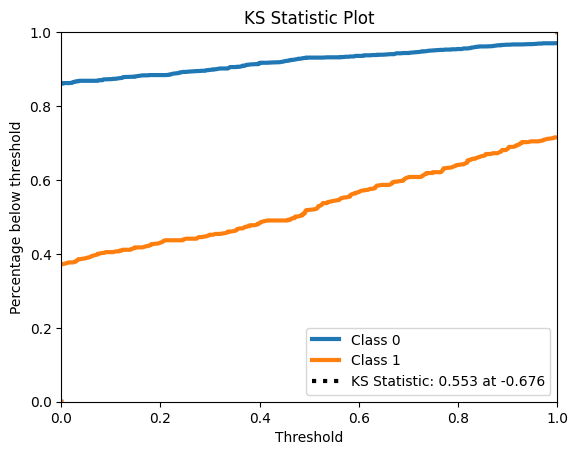

In [41]:
#@title Teste Kolmogorov-Smirnov

stab_ks = plot_ks(y_test, stab_preds_scores)

In [42]:
#@title MSE

stab_mse = mean_squared_error(y_test, stab_preds_class)
print(f"MSE: {stab_mse}")

MSE: 0.18828213879408418


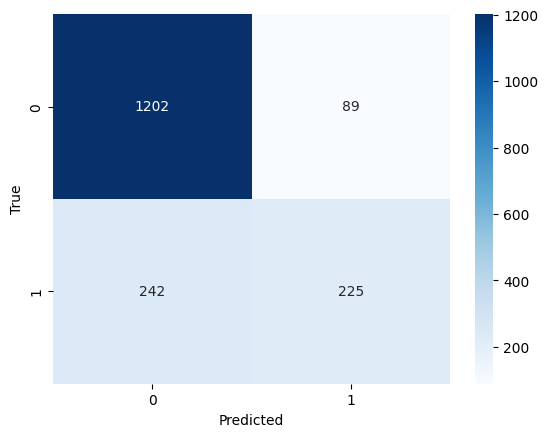

In [43]:
#@title Matriz de confusão

stab_cm = confusion_matrix(y_test, stab_preds_class)
plot_conf_matrix(stab_cm)

AUC-ROC: 0.8505018270119108


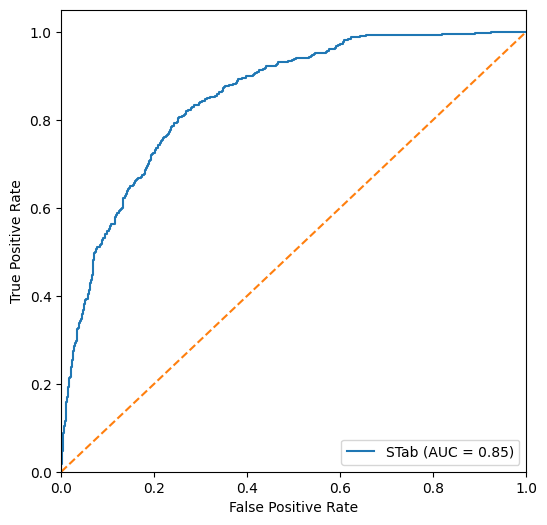

In [44]:
#@title AUC-ROC

stab_auc = roc_auc_score(y_test, stab_preds)
print(f"AUC-ROC: {stab_auc}")
stab_fpr, stab_tpr, _ = roc_curve(y_test, stab_preds)
plot_roc(stab_fpr, stab_tpr, stab_auc, 'STab')

In [45]:
#@title Recall, precision e f-score

stab_recall = recall_score(y_test, stab_preds_class)
stab_precision = precision_score(y_test, stab_preds_class)
stab_f1 = f1_score(y_test, stab_preds_class)
print(f"Recall: {stab_recall}")
print(f"Precision: {stab_precision}")
print(f"F1-score: {stab_f1}")

Recall: 0.4817987152034261
Precision: 0.7165605095541401
F1-score: 0.5761843790012804


### Otimização com optuna

In [46]:
#@title Otimização do STab com Optuna

# preparação dos dados
X_train_t = torch.tensor(X_train.astype(np.float32).values).to('cuda')
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to('cuda')
X_val_t = torch.tensor(X_val.astype(np.float32).values).to('cuda')
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to('cuda')
X_test_t = torch.tensor(X_test.astype(np.float32).values).to('cuda')
y_test_t = torch.tensor(y_test.values,  dtype=torch.float32).unsqueeze(1).to('cuda')

# define a prunning callback
class OptunaPruningCallback(keras4torch.callbacks.Callback):
  def __init__(self, trial, monitor='val_roc_auc'):
    super().__init__()
    self.trial = trial
    self.monitor = monitor

  def on_epoch_end(self, trainer):
    epoch = trainer.epoch
    intermediate_value = trainer.logger.metrics.get(self.monitor, None)

    if intermediate_value is not None:
        self.trial.report(intermediate_value, epoch)

    # Check if the trial should be pruned
    if self.trial.should_prune():
        raise optuna.exceptions.TrialPruned()

# A função de otimização de hiperparâmetros.
def objective_stab(trial):
    # Sugere os hiperparâmetros, conforme a especificação do projeto.
    dim = trial.suggest_categorical('dim', [8, 16, 32])
    depth = trial.suggest_int('depth', 2, 4)
    heads = trial.suggest_categorical('heads', [2, 4])
    attn_dropout = trial.suggest_float('attn_dropout', 0.1, 0.5)
    ff_dropout = trial.suggest_float('ff_dropout', 0.1, 0.5)
    U = trial.suggest_categorical('U', [2, 4])
    cases = trial.suggest_categorical('cases', [4, 8])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    sample_size = trial.suggest_categorical('sample_size', [8, 16, 32])

    #Aqui pega os melhores parametros achados e utiliza para criar um modelo com esse parametros
    Or_model = mainmodel.MainModel(
        categories        = (),
        num_continuous    = 39,
        dim               = dim,
        dim_out           = 1,
        depth             = depth,
        heads             = heads,
        attn_dropout      = attn_dropout,
        ff_dropout        = ff_dropout,
        U                 = U,
        cases             = cases,
    )

    model_wrapper = Num_Cat(Or_model, num_number=39, classes=1, Sample_size=sample_size)
    model = keras4torch.Model(model_wrapper).build([39]).to('cuda')
    model_optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    model.compile(optimizer=stab_optimizer, loss=torch.nn.BCEWithLogitsLoss(), metrics=['roc_auc'])

    model_early_stopping = keras4torch.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0)
    optuna_pruner_callback = OptunaPruningCallback(trial, monitor='val_roc_auc')
    model.fit([X_train_t], y_train_t,
              epochs=10000, batch_size=batch_size,
              validation_data=([X_val_t], y_val_t),
              callbacks=[model_early_stopping, optuna_pruner_callback],
              verbose=0)

    y_pred = model.predict([X_val_t]).squeeze()
    auc_score = roc_auc_score(y_val, y_pred)

    return auc_score

# Cria o estudo do Optuna e executa a otimização
print("Iniciando a busca pelos hiperparametros do modelo STab...")
stab_pruner = optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=5)
study_stab = optuna.create_study(direction='maximize', pruner=stab_pruner)
study_stab.optimize(objective_stab, n_trials=10)

print("\n--- Resultados da Otimização do STab ---")
print("Melhores hiperparametros encontrados:")
print(study_stab.best_params)
print("\nMelhor Area AUC no conjunto de validação:")
print(study_stab.best_value)

[I 2025-08-11 01:19:36,341] A new study created in memory with name: no-name-905c2446-f028-4ae3-ba4b-9be5e3022bd6


Iniciando a busca pelos hiperparametros do modelo STab...


[I 2025-08-11 01:25:30,777] Trial 0 finished with value: 0.4068223925479808 and parameters: {'dim': 8, 'depth': 2, 'heads': 2, 'attn_dropout': 0.44816816308330687, 'ff_dropout': 0.2993084439893555, 'U': 2, 'cases': 4, 'learning_rate': 0.00034805982304868374, 'weight_decay': 0.00153899079751748, 'batch_size': 64, 'sample_size': 16}. Best is trial 0 with value: 0.4068223925479808.
[I 2025-08-11 01:34:24,602] Trial 1 finished with value: 0.39981622068114453 and parameters: {'dim': 8, 'depth': 3, 'heads': 4, 'attn_dropout': 0.30448822553353355, 'ff_dropout': 0.4358186587100824, 'U': 4, 'cases': 4, 'learning_rate': 4.225752123890906e-05, 'weight_decay': 0.0003364413075696959, 'batch_size': 32, 'sample_size': 16}. Best is trial 0 with value: 0.4068223925479808.
[I 2025-08-11 01:40:34,210] Trial 2 finished with value: 0.6037797501065688 and parameters: {'dim': 32, 'depth': 4, 'heads': 2, 'attn_dropout': 0.16055995328377431, 'ff_dropout': 0.37906090631994116, 'U': 2, 'cases': 8, 'learning_rate


--- Resultados da Otimização do STab ---
Melhores hiperparametros encontrados:
{'dim': 16, 'depth': 3, 'heads': 4, 'attn_dropout': 0.33607957714514514, 'ff_dropout': 0.22885851160274845, 'U': 4, 'cases': 8, 'learning_rate': 1.0061394644866771e-05, 'weight_decay': 0.0003269269589201241, 'batch_size': 64, 'sample_size': 32}

Melhor Area AUC no conjunto de validação:
0.6998226894477829


#### Avaliação com melhor modelo

In [47]:
#@title Criando melhor modelo

best_Or_model = mainmodel.MainModel(
    categories        = (),
    num_continuous    = 39,
    dim               = study_stab.best_params['dim'],
    dim_out           = 1,
    depth             = study_stab.best_params['depth'],
    heads             = study_stab.best_params['heads'],
    attn_dropout      = study_stab.best_params['attn_dropout'],
    ff_dropout        = study_stab.best_params['ff_dropout'],
    U                 = study_stab.best_params['U'],
    cases             = study_stab.best_params['cases']
)

best_stab_wrapper = Num_Cat(best_Or_model, num_number=39, classes=1, Sample_size=study_stab.best_params['sample_size'])
best_stab = keras4torch.Model(best_stab_wrapper).build([39]).to('cuda')

best_stab_optimizer = torch.optim.AdamW(
    best_stab.parameters(),
    lr=study_stab.best_params['learning_rate'],
    weight_decay=study_stab.best_params['weight_decay'])

best_stab.compile(optimizer=best_stab_optimizer, loss=torch.nn.BCEWithLogitsLoss(), metrics=['roc_auc'])
best_stab.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─MainModel: 1-1                         [8, 1]                    --
|    └─NumericalEmbedder: 2-1            [8, 39, 16]               --
|    |    └─LWTA: 3-1                    [8, 39, 8]                1
|    └─Transformer: 2-2                  [8, 40, 16]               --
|    └─Sequential: 2-3                   [8, 1]                    --
|    |    └─Dropout: 3-2                 [8, 16]                   --
|    |    └─LayerNorm: 3-3               [8, 16]                   32
|    |    └─Linear: 3-4                  [8, 1]                    17
Total params: 50
Trainable params: 50
Non-trainable params: 0
Total mult-adds (M): 0.08


In [48]:
#@title Treinando melhor modelo

best_stab_early_stopping = keras4torch.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0)
best_stab.fit([X_train_t], y_train_t,
              epochs=10000, batch_size=study_stab.best_params['batch_size'],
              validation_data=([X_val_t], y_val_t),
              callbacks=[best_stab_early_stopping],
              verbose=0)

,loss,auc,val_loss,val_auc,lr
1,0.644087,0.504759,0.614930,0.570804,0.00001
2,0.627946,0.514952,0.603445,0.557014,0.00001
3,0.620319,0.488470,0.594351,0.577768,0.00001
4,0.607190,0.523490,0.585768,0.612683,0.00001
5,0.602555,0.518216,0.580495,0.634087,0.00001
...,...,...,...,...,...
370,0.445637,0.819657,0.443060,0.824351,0.00001
371,0.451433,0.812153,0.442457,0.828270,0.00001
372,0.446141,0.814787,0.443391,0.825044,0.00001
373,0.448174,0.816441,0.442418,0.825898,0.00001


In [49]:
#@title Gerando predições

# Gerar predições
best_stab_preds = best_stab.predict([X_test_t]).squeeze()
best_stab_preds_class = np.where(best_stab_preds >= 0.5, 1, 0)
best_stab_preds_scores = np.concatenate([1 - best_stab_preds.reshape(-1, 1), best_stab_preds.reshape(-1, 1)], axis=1)
best_stab_preds.shape

(1758,)

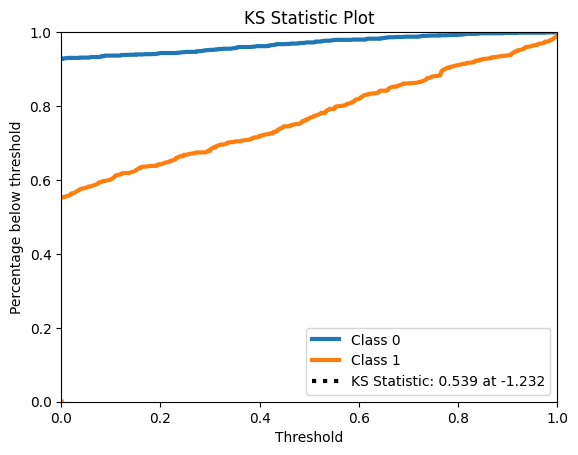

In [50]:
#@title Teste Kolmogorov-Smirnov

best_stab_ks = plot_ks(y_test, best_stab_preds_scores)

In [51]:
#@title MSE

best_stab_mse = mean_squared_error(y_test, best_stab_preds_class)
print(f"MSE: {best_stab_mse}")

MSE: 0.2235494880546075


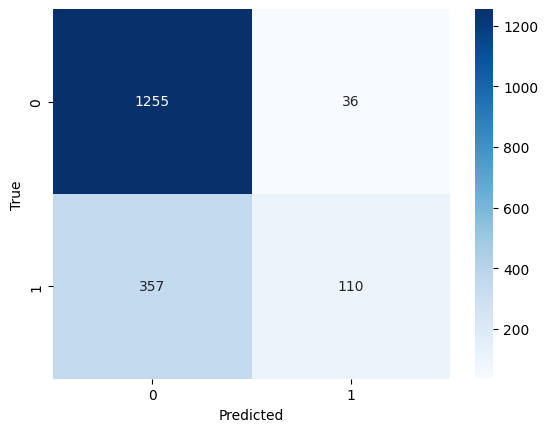

In [52]:
#@title Matriz de confusão

best_stab_cm = confusion_matrix(y_test, best_stab_preds_class)
plot_conf_matrix(best_stab_cm)

AUC-ROC: 0.8431373849927931


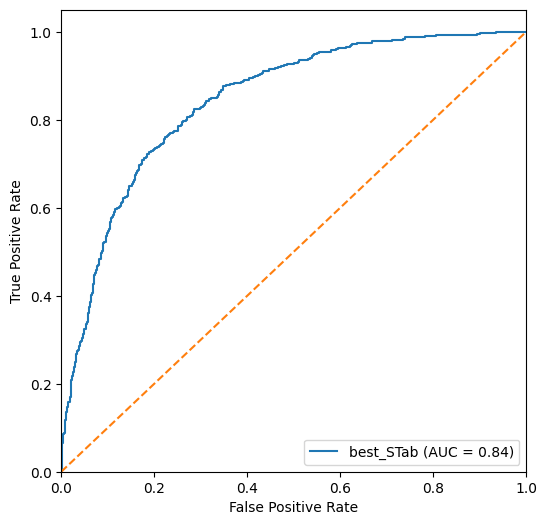

In [53]:
#@title AUC-ROC

best_stab_auc = roc_auc_score(y_test, best_stab_preds)
print(f"AUC-ROC: {best_stab_auc}")
best_stab_fpr, best_stab_tpr, _ = roc_curve(y_test, best_stab_preds)
plot_roc(best_stab_fpr, best_stab_tpr, best_stab_auc, 'best_STab')

In [54]:
#@title Recall, precision e f-score

best_stab_recall = recall_score(y_test, best_stab_preds_class)
best_stab_precision = precision_score(y_test, best_stab_preds_class)
best_stab_f1 = f1_score(y_test, best_stab_preds_class)
print(f"Recall: {best_stab_recall}")
print(f"Precision: {best_stab_precision}")
print(f"F1-score: {best_stab_f1}")

Recall: 0.23554603854389722
Precision: 0.7534246575342466
F1-score: 0.35889070146818924


## TabPFN2 Transformer

In [55]:
#@title Treinamento inicial

### Avaliação inicial

In [56]:
#@title Teste Kolmogorov-Smirnov

In [57]:
#@title (MSE ou Entropia Cruzada)

In [58]:
#@title Matriz de confusão

In [59]:
#@title AUC-ROC

In [60]:
#@title Recall, precision e f-score

## Gradient Boosting

### Primeira execução

In [61]:
#@title Definição do modelo
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_classifier

GradientBoostingClassifier(random_state=42)

In [62]:
#@title Treinamento inicial
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

#### Avaliação inicial

In [63]:
#@title Gerando predições
gb_preds = gb_classifier.predict(X_test)
gb_preds_0 = 1 - gb_preds
gb_preds_scores = np.concatenate([gb_preds_0.reshape(-1, 1), gb_preds.reshape(-1, 1)], axis=1)
print(f"Predições: {gb_preds.shape}")

Predições: (1758,)


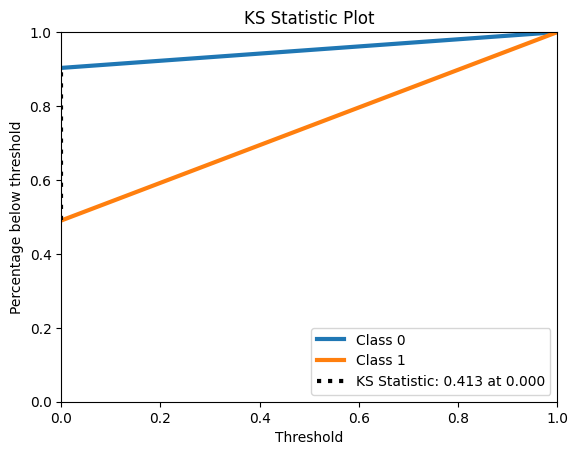

In [64]:
#@title Teste Kolmogorov-Smirnov
gb_ks = plot_ks(y_test, gb_preds_scores)

In [65]:
#@title MSE
gb_mse = mean_squared_error(y_test, gb_preds)
print(f"MSE: {gb_mse}")

MSE: 0.20136518771331058


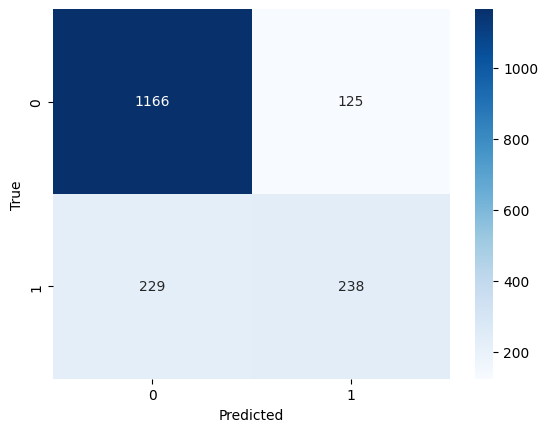

In [66]:
#@title Matriz de confusão
gb_cm = confusion_matrix(y_test, gb_preds)
plot_conf_matrix(gb_cm)

AUC-ROC: 0.7064059034959536


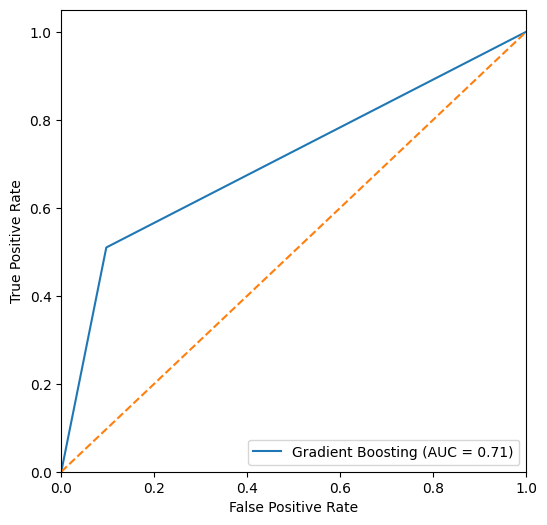

In [67]:
#@title AUC-ROC
gb_auc = roc_auc_score(y_test, gb_preds)
print(f"AUC-ROC: {gb_auc}")
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_preds)
plot_roc(gb_fpr, gb_tpr, gb_auc, 'Gradient Boosting')

In [68]:
#@title Recall, precision e f-score
gb_recall = recall_score(y_test, gb_preds)
gb_precision = precision_score(y_test, gb_preds)
gb_f1 = f1_score(y_test, gb_preds)
print(f"Recall: {gb_recall}")
print(f"Precision: {gb_precision}")
print(f"F1-score: {gb_f1}")

Recall: 0.5096359743040685
Precision: 0.6556473829201102
F1-score: 0.5734939759036145


### Otimizando com o Optuna

In [69]:
#@title Otimização do Gradient Boosting com Optuna

# A função de otimização de hiperparâmetros.
def objective_gb(trial):
    # Sugere os hiperparâmetros, conforme a especificação do projeto.
    loss = trial.suggest_categorical('loss', ['log_loss', 'exponential'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_depth = trial.suggest_int('max_depth', 2, 32)

    #Aqui pega os melhores parametros achados e utiliza para criar um modelo com esse parametros
    model = GradientBoostingClassifier(
        loss=loss,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        criterion=criterion,
        min_samples_leaf=min_samples_leaf,
        max_depth=max_depth,
        random_state=42
    )


    model.fit(X_train, y_train)


    y_pred = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred)

    return auc_score

# Cria o estudo do Optuna e executa a otimização
print("Iniciando a busca pelos hiperparametros do modelo Gradient Boosting...")
study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials=50)

print("\n--- Resultados da Otimização do Gradient Boosting ---")
print("Melhores hiperparametros encontrados:")
print(study_gb.best_params)
print("\nMelhor Area AUC no conjunto de validação:")
print(study_gb.best_value)

[I 2025-08-11 03:26:41,148] A new study created in memory with name: no-name-4aa962e1-0e4d-4aab-a34c-dbf10163316c


Iniciando a busca pelos hiperparametros do modelo Gradient Boosting...


[I 2025-08-11 03:26:42,295] Trial 0 finished with value: 0.8336009301754694 and parameters: {'loss': 'log_loss', 'learning_rate': 0.002648581305419008, 'n_estimators': 240, 'subsample': 0.4519508350590663, 'criterion': 'friedman_mse', 'min_samples_leaf': 1, 'max_depth': 3}. Best is trial 0 with value: 0.8336009301754694.
[I 2025-08-11 03:26:43,608] Trial 1 finished with value: 0.8246151498514671 and parameters: {'loss': 'exponential', 'learning_rate': 0.00011637225816370517, 'n_estimators': 57, 'subsample': 0.7324473848690454, 'criterion': 'squared_error', 'min_samples_leaf': 1, 'max_depth': 8}. Best is trial 0 with value: 0.8336009301754694.
[I 2025-08-11 03:26:45,455] Trial 2 finished with value: 0.8311287002589166 and parameters: {'loss': 'log_loss', 'learning_rate': 3.127945948012083e-05, 'n_estimators': 135, 'subsample': 0.5654029586525622, 'criterion': 'squared_error', 'min_samples_leaf': 3, 'max_depth': 7}. Best is trial 0 with value: 0.8336009301754694.
[I 2025-08-11 03:26:50,6


--- Resultados da Otimização do Gradient Boosting ---
Melhores hiperparametros encontrados:
{'loss': 'log_loss', 'learning_rate': 1.3833183810390958e-05, 'n_estimators': 340, 'subsample': 0.13737425300539122, 'criterion': 'friedman_mse', 'min_samples_leaf': 10, 'max_depth': 16}

Melhor Area AUC no conjunto de validação:
0.8368759506184307


# Avaliação final

## Comparação de métricas de todos os modelos